# DC Resistivity Forward Modeling: 1D Sounding


In this notebook, we predict data for a sounding survey over a layered Earth.

## Import Modules

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

from discretize import TensorMesh

from SimPEG import maps
from SimPEG.electromagnetics.static import resistivity as dc
from SimPEG.electromagnetics.static.utils.StaticUtils import plot_layer

mpl.rcParams.update({'font.size': 14})

## User Defined Parameters for the Notebook

Here, the user defines the parameters required to run the notebook. The parameters are as follows:

- **half_AB_separation:** a numpy array containing the AB/2 values for the source electrodes
- **half_MN_separations:** a numpy array containing the MN/2 values for the receiver electrodes
- **resistivity_model:** Electrical resistivity for each layer in Ohm-meters
- **layer_thicknesses:** Layer thicknesses in meters. Defined from top layer to bottom
- **file_name:** The output file location for the data
- **add_noise:** Whether to add noise to the simulated data (Either `True` or `False`)
- **standard_deviation:** The amount of noise to add to the data set

## Define the Survey
These are the electrode locations, here we have set them for a Schlumberger sounding

In [2]:
# Make a numpy array for AB/2 values
half_AB_separation = np.r_[
    5,10,20,30,40,
    40,50,60,70,80,90,100,
    100,120,140,160,180,200,
    200,220,240,260,280,300,
    300,320,350,370,400
]  

# Make a numpy array for MN/s values
half_MN_separation = np.r_[
    1,1,1,1,1,
    5,5,5,5,5,5,5,
    10,10,10,10,10,10,
    20,20,20,20,20,20,
    30,30,30,30,30
]  

Next, we define the model parameters, the thicknesses of each layer, and the resistivities of each layer

**Note:** The `layer_thickness` has one less element than the resistivity model (the last layer is assumed to be infinitely thick)

In [3]:
# Define model. A resistivity (Ohm meters) for each layer.
resistivity_model = np.r_[400, 50, 400, 200, 2000, 20, 2000]

# Define the layer thicknesses
layer_thicknesses = np.r_[8., 8., 4., 10., 10., 10.]

Now, we set the file name where we would like to write the data out to

In [4]:
# File to output the AB/2, MN/2, apparent resistivity, and (optionally) the standard deviation
filename = 'assets/1D_Schlumberger_synthetic.csv'

Finally, we set the parameters that say if we want to add noise to the simulated data

In [5]:
# These parameters control whether (and how much) noise is added to the simulated data
add_noise = False
standard_deviation = 0.05 # Add Gaussian noise with 5% standard deviation

## Define the Survey Parameters for SimPEG

This portion of the notebook defines a Schlumberger sounding survey using the AB/2 and MN/2 values provided.

In [6]:
source_list = []  # create empty array for sources to live

for ii in range(0, len(half_AB_separation)):
    
    # AB electrode locations for source. Each is a (1, 3) numpy array
    A_location = np.r_[-half_AB_separation[ii], 0., 0.]
    B_location = np.r_[half_AB_separation[ii], 0., 0.]

    # MN electrode locations for receivers. Each is an (1, 3) numpy array
    M_location = np.r_[-half_MN_separation[ii], 0., 0.]
    N_location = np.r_[half_MN_separation[ii], 0., 0.]

    # Create receivers list. Define as pole or dipole.
    receiver = dc.receivers.Dipole(
        M_location, N_location
    )
    receiver_list = [receiver]

    # Define the source properties and associated receivers
    source = dc.sources.Dipole(receiver_list, A_location, B_location)
    
    # Add source to list of sources
    source_list.append(source)

# Define survey
survey = dc.Survey(source_list)

## Define a 1D Layered Earth 

This part of the notebook creates a layered Earth on which to compuate the forward simulation. Once created, we can plot the resistivity model on our 1D Earth.

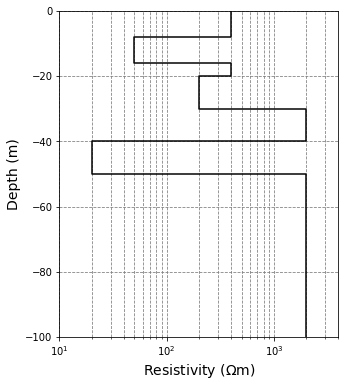

In [7]:
# Create a TensorMesh for forward modeling
mesh = TensorMesh([np.r_[layer_thicknesses, 5*layer_thicknesses[-1]]])
x_min = np.min(resistivity_model)
x_max = np.max(resistivity_model)

# Plot the 1D model
fig, ax = plt.subplots(1, 1, figsize=(5, 6))
plot_layer(resistivity_model, mesh, ax=ax, depth_axis=False)
ax.grid(True, which="both", ls="--", c='gray')
ax.set_xlim(0.5*x_min, 2*x_max);

## Define the Forward Simulation and Predict DC Resistivity Data

In this part of the notebook, all the pieces needed to predict the data are assembled into a *simulation*. Once created, we can predict data for a given *resistivity model*. We have chosen to predicte the data in terms of apparent resistivity, as opposed to raw voltage. Once the data are predicted, we plot the Schlumberger sounding curve.

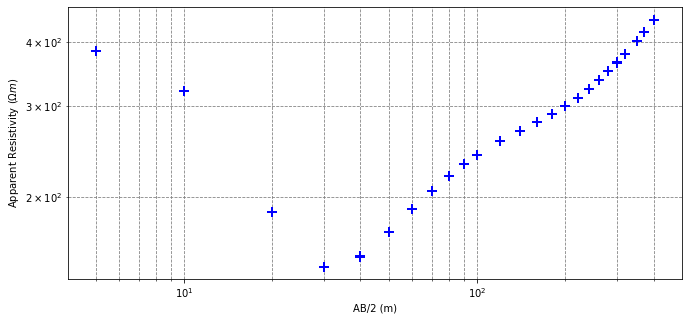

In [9]:
# Define mapping from model to active cells. Here, all layers are use in the
# forward simulation.
model_map = maps.IdentityMap(mesh)

# Create a simulation object
simulation = dc.simulation_1d.Simulation1DLayers(
    survey=survey, rhoMap=model_map, thicknesses=layer_thicknesses,
    data_type="apparent_resistivity"
)

# Predict data for a given model, with noise
data_obj = simulation.make_synthetic_data(
    resistivity_model,
    standard_devation=standard_deviation, add_noise=add_noise
)

# Plot apparent resistivities on sounding curve
fig, ax = plt.subplots(1, 1, figsize=(11, 5))
ax.loglog(half_AB_separation, data_obj.dobs, 'b+', ms=10, mew=2)
ax.set_xlabel("AB/2 (m)")
ax.set_ylabel("Apparent Resistivity ($\Omega m$)")
ax.grid(True, which="both", ls="--", c='gray')

In [10]:
out_dat = np.c_[half_AB_separation, half_MN_separation, data_obj.dobs]
columns = ['AB/2 (m)','MN/2 (m)','App. Res. (Ohm m)']
if add_noise:
    columns += ['uncertainty (Ohm m)']
    out_dat = np.c_[out_dat, data_obj.uncertainty]
df = pd.DataFrame(out_dat, columns=columns)
df.to_csv(filename, index=False)

FileNotFoundError: [Errno 2] No such file or directory: 'assets/1D_Schlumberger_synthetic.csv'